In [59]:
# import the libraries
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from numpy.core.umath_tests import inner1d

In [60]:
#load the data
df = pd.read_csv('Bitcoin_Data/last_5years_data.csv', parse_dates=['Date'],index_col='Date')
df=df.sort_values(by='Date')
df.tail()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-12-14,19273.91638,19540.78258,19086.03263,19434.07031,3.720726e+10,3.592630e+11
2020-12-15,19424.01073,21395.55444,19306.67714,21367.09631,4.822748e+10,3.724990e+11
2020-12-16,21349.65670,23656.65347,21265.80118,22823.45909,1.199670e+11,4.197790e+11
2020-12-17,22796.24924,23239.69877,22397.09551,23113.99259,1.170190e+11,4.248080e+11
2020-12-18,23131.04460,24077.49414,22830.89779,23844.56807,6.365550e+10,4.334090e+11


In [61]:
#check  if there are any null values in the data
df.isnull().any()

Open          False
High          False
Low           False
Close         False
Volume        False
Market Cap    False
dtype: bool

In [62]:
#Data dimension reduction
df.drop(['Volume','Market Cap'], axis=1, inplace =True)
df.tail()

,Open,High,Low,Close
Date,,,,
2020-12-14,19273.91638,19540.78258,19086.03263,19434.07031
2020-12-15,19424.01073,21395.55444,19306.67714,21367.09631
2020-12-16,21349.65670,23656.65347,21265.80118,22823.45909
2020-12-17,22796.24924,23239.69877,22397.09551,23113.99259
2020-12-18,23131.04460,24077.49414,22830.89779,23844.56807


In [63]:
#outlier detection
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2063 entries, 2015-04-27 to 2020-12-18
Data columns (total 4 columns):
Open     2063 non-null float64
High     2063 non-null float64
Low      2063 non-null float64
Close    2063 non-null float64
dtypes: float64(4)
memory usage: 80.6 KB


In [64]:
df.describe()
#.shape 

,Open,High,Low,Close
count,2063.000000,2063.000000,2063.000000,2063.000000
mean,5297.303880,5434.659028,5155.711449,5308.761604
std,4565.207936,4706.356332,4421.531524,4582.321807
min,210.495000,225.719000,199.567000,211.394000
25%,657.182500,666.491500,648.766500,657.090000
50%,4817.774916,4975.040000,4577.272431,4879.760000
75%,8756.366934,8947.282527,8551.827868,8770.402076
max,23131.044600,24077.494140,22830.897790,23844.568070


In [65]:
#identify outliers with interquartile range(IQR)
q1=df.quantile(0.25)
q3=df.quantile(0.75)
IQR=q3-q1
IQR


Open     8099.184434
High     8280.791027
Low      7903.061368
Close    8113.312076
dtype: float64

In [66]:
#print(df < (q1- 1.5* IQR)) | (df > (q3+1.5*IQR))


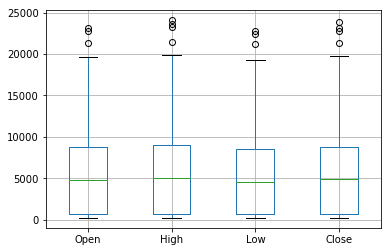

In [67]:
df.boxplot()

In [68]:
#df.hist()

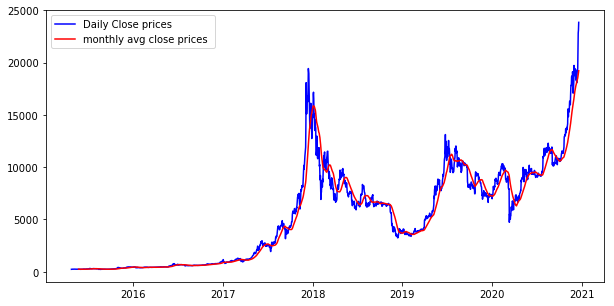

In [69]:
#plot graph to visualize the data
plt.figure(figsize=(10,5))
plt.plot(df['Close'],color = 'blue', label ='Daily Close prices')
plt.plot(df['Close'].rolling(window=30).mean(),color = 'red', label ='monthly avg close prices ')
plt.legend()

In [70]:
# Feature expansion
df['Average'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df.head()

,Open,High,Low,Close,Average
Date,,,,,
2015-04-27,229.286,229.495,223.069,225.749,226.89975
2015-04-28,225.855,227.040,223.430,226.002,225.58175
2015-04-29,225.808,239.563,224.993,235.997,231.59025
2015-04-30,236.145,238.966,232.155,232.155,234.85525
2015-05-01,232.079,235.727,232.079,235.027,233.72800


In [71]:
# create label/target var for our data set
df['Price_After_2weeks']= df['Close'].shift(-15)
df.head()

,Open,High,Low,Close,Average,Price_After_2weeks
Date,,,,,,
2015-04-27,229.286,229.495,223.069,225.749,226.89975,236.525
2015-04-28,225.855,227.040,223.430,226.002,225.58175,236.886
2015-04-29,225.808,239.563,224.993,235.997,231.59025,237.589
2015-04-30,236.145,238.966,232.155,232.155,234.85525,236.185
2015-05-01,232.079,235.727,232.079,235.027,233.72800,236.796


In [72]:
df.shape

(2063, 6)

In [73]:
#Preprocessing and separating the feature and target variables
from sklearn import preprocessing
#drop null values
df.dropna(inplace=True)
# separate x and y
X=df.drop('Price_After_2weeks',axis=1)
X=preprocessing.scale(X)#We need to scale our values to input them in our model
Y=df['Price_After_2weeks']

In [74]:
# separate the train and the text set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [75]:
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (1638, 5)
y_train (1638,)
X_test (410, 5)
y_test (410,)


# 1.SVM

In [76]:
# Build 2 models

poly_svr = SVR(kernel='poly', C=1000.0, degree =2)
poly_svr.fit(x_train, y_train)

rbf_svr = SVR(kernel='rbf', C=1000.0, gamma=0.85)
Rbf_model=rbf_svr.fit(x_train, y_train)

In [77]:
#test svm models accuracy.
#accuracy1 =lin_svr.score(x_test,y_test)
#lin_score=float(accuracy1)*100
#print("Linear svm accuacy is:", lin_score)

accuracy2 =poly_svr.score(x_test,y_test)
#poly_score=float(accuracy2)*100
print("Polynomial svm accuracy is:", accuracy2)

accuracy3 =Rbf_model.score(x_test,y_test)
rbf_score=float(accuracy3)*100
print("RBF svm accuracy is:", rbf_score)

Polynomial svm accuracy is: 0.2086610318678066
RBF svm accuracy is: 90.92217159933779


In [78]:
#use the Gaussian svm to make pedictions
rbf_preds= Rbf_model.predict(x_test)
print("The Rbf prediction is:", rbf_preds[1],'\n',"The Actual price is:  " ,y_test[1])

The Rbf prediction is: 443.77524660601193 
 The Actual price is:   538.0169999999999


In [79]:
#save the model
filename = 'Trained_models/'+'rbf.sav'

#pickle.dump(Rbf_model, open(filename, 'wb'))

In [80]:
#covert the predictions and actual values DataFrame
rbf_df=pd.DataFrame({'Predictions':rbf_preds,'Actual_prices':y_test})
# reset the index to normal data frame indexing
rbf_df.reset_index(drop=True, inplace=True)
#rename the column
rbf_df["index"]=rbf_df.index
rbf_df.head()

,Predictions,Actual_prices,index
0,6660.720899,6364.401842,0
1,443.775247,538.017000,1
2,5699.337234,5820.358392,2
3,1426.298865,1488.820000,3
4,8303.752989,8672.985373,4


In [81]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rbf_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rbf_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rbf_preds)))

Mean Absolute Error: 793.5726167724016
Mean Squared Error: 2164349.0964274737
Root Mean Squared Error: 1471.1726942910113


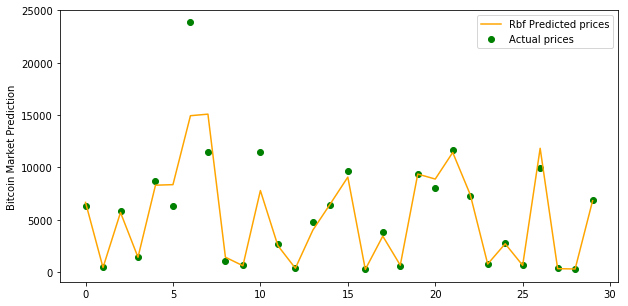

In [82]:
# plot predictions
plt.figure(figsize=(10,5))
#plot the actual prices on scatter plot
plt.scatter(rbf_df['index'].head(30),rbf_df['Actual_prices'].head(30), color ='green', label='Actual prices')
# plot rbf model predictions
plt.plot(rbf_df['Predictions'].head(30), color = 'orange', label ='Rbf Predicted prices')
plt.ylabel('Bitcoin Market Prediction')
plt.legend()
plt.show()

# 2.Linear Regression 

In [83]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
LR= regressor.fit(x_train, y_train)

In [84]:
print(LR.intercept_)

5340.931510998562


In [85]:
#test the accuracy
accuracy=LR.score(x_test,y_test)
accuracy=float(accuracy)*100
print('Linear regresssion accuracy is {0:.2f} %'.format(accuracy))

Linear regresssion accuracy is 91.52 %


In [86]:
#Linear regresssion predictions
LR_preds=LR.predict(x_test)
print("The Linear regression prediction is:", LR_preds[2],'\n',"The Actual price is:  " ,y_test[2])

The Linear regression prediction is: 5521.176364242056 
 The Actual price is:   5820.358392


In [87]:
#convert array values to pandas.
lr_df=pd.DataFrame({'Predictions':LR_preds,'Actual_prices':y_test})
lr_df.reset_index(drop=True, inplace=True)
lr_df['index']=lr_df.index
lr_df.head()

,Predictions,Actual_prices,index
0,6727.817538,6364.401842,0
1,601.261793,538.017000,1
2,5521.176364,5820.358392,2
3,1363.465592,1488.820000,3
4,8098.195881,8672.985373,4


In [88]:
#save the Linear regression model
filename = 'Trained_models/'+'linearRegression.sav'
#pickle.dump(LR, open(filename, 'wb'))

In [89]:
#evaluating the algorith
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, LR_preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, LR_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, LR_preds)))

Mean Absolute Error: 819.4939758390565
Mean Squared Error: 2021660.7278313008
Root Mean Squared Error: 1421.8511623342652


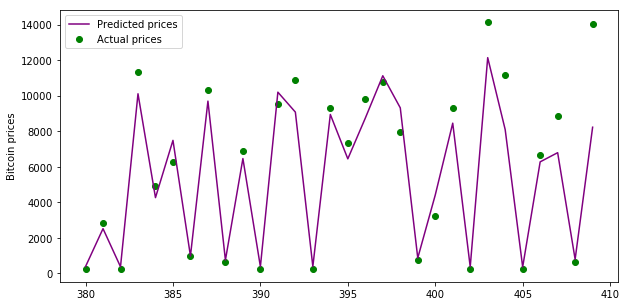

In [90]:
#plot Linear regressions predictions
plt.figure(figsize=(10,5))
plt.scatter(lr_df['index'].tail(30), lr_df['Actual_prices'].tail(30), color='green', label="Actual prices")
plt.plot(lr_df['Predictions'].tail(30), color='purple', label="Predicted prices")
plt.ylabel("Bitcoin prices")
plt.legend()

# 3. Random Forest

In [91]:
# fit the model on training set 
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=100,random_state=0)
model = reg.fit(x_train,y_train)

In [92]:
# Test the RandomForest accuracy and predictons!
acc=model.score(x_test,y_test)
score=float(acc)*100
print('The model accuracy is: {0:.2f} % \n'.format(score))#This percentage shows how much our regression fits our data

# test the model
randf_preds = model.predict(x_test)
print("The predicted price is:", randf_preds[1],'\n', "The Actual value is:  " ,y_test[1])

The model accuracy is: 91.89 % 

The predicted price is: 492.4118000000006 
 The Actual value is:   538.0169999999999


In [35]:
#save model
file ='Trained_models/'+'randomforest.sav'
#pickle.dump(model, open(file, 'wb'))

In [36]:
#Evaluating the random forest regressor model algorithm using the error metrics.
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, randf_preds))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, randf_preds))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, randf_preds)))

Mean Absolute Error: 742.9385772670489
Root Mean Squared Error: 1409.5033176187098


In [37]:
#convert predicted and actual values to data frame
df1=pd.DataFrame({'Actual_values':y_test,'RandomF_Preds':randf_preds})
#drop the date index
df1.reset_index(drop=True, inplace=True)
#create  new index column
df1["index"]=df1.index
df1.head()

,Actual_values,RandomF_Preds,index
0,11266.401340,10274.601291,0
1,5363.756655,5282.484367,1
2,435.101000,419.525290,2
3,11095.091960,9210.586108,3
4,8216.796397,7256.281538,4


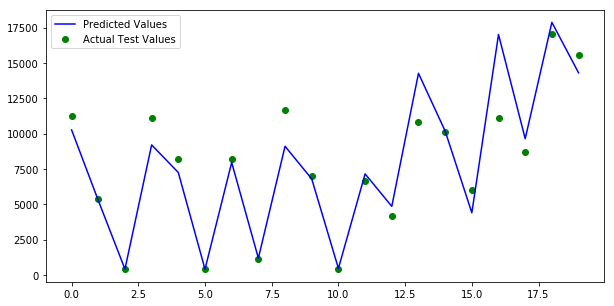

In [38]:
#plot Random Forest predictions
plt.figure(figsize=(10,5))
plt.scatter(x =df1['index'].head(20), y=df1['Actual_values'].head(20), color='green', label='Actual Test Values')
plt.plot(df1['RandomF_Preds'].head(20), color='blue', label='Predicted Values')
plt.legend()
plt.show()

# Forecast

In [50]:
#lets make our prediction on the last 30 elements 
x_30=X[-30:] # 
predictions =model.predict(x_30)
#X_30

In [51]:
# date counter
last_date= df.iloc[-1].name #df.iloc[:,-1]
last_date

Timestamp('2021-02-02 00:00:00')

In [52]:
#create a new column to add predictions 
modified_date = last_date + timedelta(days=1)
#increment the dates for tor the spwcified periods
Date=pd.date_range(modified_date,periods=30)
col=['Predictions']
preds = pd.DataFrame(predictions,columns= col,index=Date)
df =df.append(preds, sort=True)
df.tail()

,Average,Close,High,Low,Open,Predictions,Price_After_2weeks
2021-02-28,NaN,NaN,NaN,NaN,NaN,16254.064321,NaN
2021-03-01,NaN,NaN,NaN,NaN,NaN,20202.310800,NaN
2021-03-02,NaN,NaN,NaN,NaN,NaN,20576.322931,NaN
2021-03-03,NaN,NaN,NaN,NaN,NaN,17993.563956,NaN
2021-03-04,NaN,NaN,NaN,NaN,NaN,22237.028256,NaN


([<matplotlib.lines.Line2D at 0x2027fcf6b08>],
 [<matplotlib.lines.Line2D at 0x2027f38fcc8>])

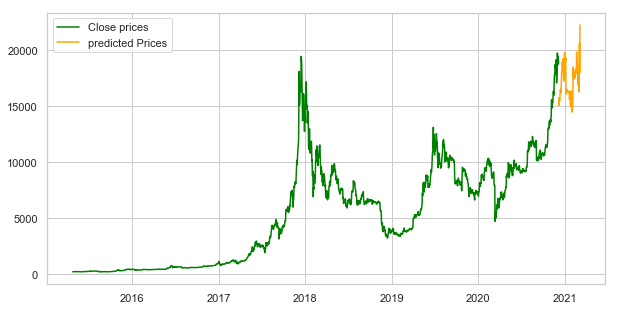

In [53]:
# Plot the predictions!
def PlotPredictions():
    plt.figure(figsize=(10,5))  
    sns.set()
    sns.set_style('whitegrid')
    result1 = plt.plot(df['Close'],  color ='green', label='Close prices')
    result2= plt.plot(df['Predictions'], color = 'orange', label='predicted Prices')
    plt.legend()
    return result1,result2
PlotPredictions()